In [1]:
from __future__ import print_function
from keras.models import Model
from keras.layers import Dense, Activation, Input, Embedding, Reshape
from keras.layers import LSTM, GRU, Conv1D
from keras.layers.wrappers import TimeDistributed
from keras.activations import sigmoid
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.callbacks import TensorBoard
import numpy as np
import random
import sys
import os

Using TensorFlow backend.


In [2]:
from libs.utils import text_preprocess

In [3]:
with open('data/dostoewskij.txt', encoding='utf-8') as f:
    dostoewskij_text = f.read().lower()
with open('data/non_dostoewskij_texts.txt', encoding='utf-8') as f:
    non_dostoewskij_text = f.read().lower()

dostoewskij_text = text_preprocess(dostoewskij_text)
non_dostoewskij_text = text_preprocess(non_dostoewskij_text)

# dostoewskij_text = clear_text_from_rare_chars(dostoewskij_text, delete_enters=True)
# non_dostoewskij_text = clear_text_from_rare_chars(non_dostoewskij_text, delete_enters=True)

print('dostoewskij_length:\t', len(dostoewskij_text))
print('non_dostoewskij_length:\t', len(non_dostoewskij_text))

dostoewskij_length:	 4911415
non_dostoewskij_length:	 173623913


In [4]:
from libs.utils import load_transformer

transformer = load_transformer('models/shm_c1')

chars = transformer.tokens
char_cats = len(chars)
print('total chars:', char_cats)

total chars: 42


In [5]:
print_len = 2000
pos = np.random.randint(len(dostoewskij_text))
print(dostoewskij_text[pos:pos+print_len])
print('-' * 100)
pos = np.random.randint(len(non_dostoewskij_text))
print(non_dostoewskij_text[pos:pos+print_len])

ержание ее хотя и форма прекрасная. содержание же 

неоспоримо. вот почему мы можем в радости предаться новой надежде: слишком 

очистился горизонт наш, слишком ярко всходит новое солнце наше... и если б 

только возможно было, чтоб мы все согласились и сошлись с народом в понимании: 

кого отселе считать человеком "лучшим", то с нынешнего лета, может быть, зачался 

бы новый период истории русской. 



ф. м. достоевский

дневник писателя

ежемесячное издание 

 

ноябрь 

глава первая 

кроткая фантастический 

рассказ 



от автора 



я прошу извинения у моих читателей, что на сей раз вместо 

"дневника" в обычной его форме даю лишь повесть. но я действительно занят был 

этой повестью большую часть месяца. во всяком случае прошу снисхождения 

читателей. 

теперь о самом рассказе. я озаглавил его "фантастическим", 

тогда как считаю его сам в высшей степени реальным. но фантастическое тут есть 

действительно, и именно в самой форме рассказа, что и нахожу нужным пояснить 

предвари

In [6]:
n_batches = len(dostoewskij_text) // 3000
batch_size = 16
#n_batches -= n_batches % batch_size
max_len = 200

In [11]:
# transform text into sequence of indices
dostoewskij_indexes        = transformer.transform(dostoewskij_text)
non_dostoewskij_indexes = transformer.transform(non_dostoewskij_text)

In [12]:
def split_data_into_correct_batches(text1_indexes, text2_indexes, make_equal_folding = True):
    prime_number = 2147483647
    
    X = np.zeros((n_batches, max_len), dtype=np.int64)
    Y = np.zeros((n_batches,), dtype=np.int64)
    
    choose_from_first = True
    index1 = 0
    index2 = 0
    for i in range(n_batches):
        if make_equal_folding:
            if choose_from_first:
                index1 = (index1 + prime_number) % (len(text1_indexes) - max_len + 1)
                X[i, :] = text1_indexes[index1:index1+max_len]
                Y[i] = 0
            else:
                index2 = (index2 + prime_number) % (len(text2_indexes) - max_len + 1)
                X[i, :] = text2_indexes[index2:index2+max_len]
                Y[i] = 1
                
            choose_from_first = not choose_from_first
        else:
            index1 = (index1 + prime_number) % (len(text1_indexes) + len(text2_indexes) - 2*max_len + 2)
            if index1 < len(text1_indexes) - max_len + 1:
                X[i, :] = text1_indexes[index1:index1 + max_len]
                Y[i] = 0
            else:
                index2 = index1 - (len(text1_indexes) - max_len + 1)
                X[i, :] = text2_indexes[index2:index2 + max_len]
                Y[i] = 1
    return X, Y

X, y = split_data_into_correct_batches(dostoewskij_indexes, non_dostoewskij_indexes, make_equal_folding=True)

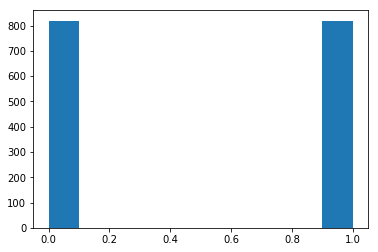

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

a = plt.hist(y)

In [14]:
from keras.losses import sparse_categorical_crossentropy

In [15]:
def create_char_rnn():
    inp = Input(shape=(max_len,), dtype="int32")
    v = Embedding(char_cats, int(char_cats / 1.5))(inp)
    h1 = GRU(256, stateful=False, return_sequences=True, unroll=True, implementation=0)(v)
    h2 = GRU(256, stateful=False, return_sequences=False, unroll=True, implementation=0)(h1)
    y = Dense(2, activation='softmax')(h2)
    model = Model(inp, y, name="char_rnn")
    model.compile(optimizer=RMSprop(), loss=sparse_categorical_crossentropy, metrics=['accuracy'])
    return model

In [16]:
rnn = create_char_rnn()

In [17]:
print(rnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 28)           1176      
_________________________________________________________________
gru_1 (GRU)                  (None, 200, 256)          218880    
_________________________________________________________________
gru_2 (GRU)                  (None, 256)               393984    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 614,554
Trainable params: 614,554
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = rnn.fit(X, y, batch_size=batch_size, shuffle=True, epochs=1)#, callbacks=[tb])

Epoch 1/1


In [ ]:
n_epochs = 8
histories = []
for epoch in range(n_epochs):
    X, y = split_data_into_correct_batches(dostoewskij_indexes, non_dostoewskij_indexes, make_equal_folding=True)
    histories.append(rnn.fit(X, y, batch_size=batch_size, shuffle=True, epochs=1))

In [ ]:
rnn.save('models/discriminator_style_rnn_model.h5')